# Gaussian Sparsse Parity

In [66]:
# import modules
import numpy as np
from tensorflow import keras
from kdg.kdn import *
from kdg.utils import gaussian_sparse_parity
import seaborn as sns
sns.set_context('talk')

In [67]:
# define the experimental setup
p = 20 # total dimensions of the data vector
p_star = 3 # number of signal dimensions of the data vector

In [68]:
# generate data
X, y = gaussian_sparse_parity(
    10000,
    p_star=p_star,
    p=p
)
X_test, y_test = gaussian_sparse_parity(
    1000,
    p_star=p_star,
    p=p
)
X_val, y_val = gaussian_sparse_parity(
    500,
    p_star=p_star,
    p=p
)

In [69]:
# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-3),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=False)
fit_kwargs = {
    "epochs": 200,
    "batch_size": 32,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [70]:
# network architecture
def getNN():
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base = keras.Sequential()
    network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer, input_shape=(20,)))
    network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [71]:
# train Vanilla NN
vanilla_nn = getNN()
vanilla_nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

# train KDN
model_kdn = kdn(
    network=vanilla_nn,
    polytope_compute_method="all",
    k=1e-5,
    weighting_method="lin",
    T=2,
    c=2,
    verbose=False,
)
model_kdn.fit(X, y)

In [72]:
accuracy_kdn = np.mean(
        model_kdn.predict(X_test) == y_test
    )
accuracy_nn = np.mean(
        np.argmax(vanilla_nn.predict(X_test), axis=1) == y_test
    )

print("NN Accuracy:", accuracy_nn)
print("KDN Accuracy:", accuracy_kdn)

NN Accuracy: 0.918
KDN Accuracy: 0.915


In [73]:
def compute_weights(X_, polytope_id):
    M_ref = model_kdn._get_activation_pattern(polytope_id)
    start = 0
    A = X_
    A_ref = X_
    d = 0
    for l in range(len(model_kdn.network_shape)-1):
        end = start + model_kdn.network_shape[l]
        M_l = M_ref[start:end]
        start = end
        W, B = model_kdn.weights[l], model_kdn.biases[l]
        pre_A = A @ W + B
        A = np.maximum(0, pre_A)
        pre_A_ref = A_ref @ W + B
        A_ref = pre_A_ref @ np.diag(M_l) 
        d += np.linalg.norm(A - A_ref, axis=1, ord=2)
    scales = np.exp(-d)
    # scales = d
    return scales

In [74]:
X_0 = X[y==0] # data that belong to class 0

# pick the point closest to the class mean
idx = np.linalg.norm(X_0[:, :3] - [0.5, 0.5, 0.5], ord=2, axis=1).argsort()[0]
X_ref = X_0[idx]
x_ref = X_ref[:3]

# define the distances
d = np.arange(0.1, 10, 0.1)

# get the activation pattern of the reference point
X_ref_polytope_id = model_kdn._get_polytope_memberships(X_ref.reshape(1, len(X_ref)))[0][0]
a_ref = np.binary_repr(X_ref_polytope_id, width=model_kdn.num_fc_neurons)[::-1]
a_ref = np.array(list(a_ref)).astype('int')

rep = 300
distance_replicates = {}
for i in range(len(d)):
    tmpp_array = []
    for j in range(rep):
        # sample points which has the same distance from the reference point
        u = np.random.normal(0,1,3)
        u_norm = np.linalg.norm(u)
        x_bar = u/u_norm * d[i] + x_ref
        X_bar = X_ref.copy()

        X_bar[:3] = x_bar

        # inference
        X_bar_polytope_id = model_kdn._get_polytope_memberships(X_bar.reshape(1, len(X_bar)))[0][0]
        a_bar = np.binary_repr(X_bar_polytope_id, width=model_kdn.num_fc_neurons)[::-1]
        a_bar = np.array(list(a_bar)).astype('int')
        tmpp_array.append(X_bar)
    distance_replicates[d[i]] = tmpp_array

In [75]:
mean_weights = []
quantile_25_weights = []
quantile_75_weights = []
for i in range(len(d)):
    weights_per_distance = []
    for j in range(rep):
        X_bar = distance_replicates[d[i]][j]
        weight = compute_weights(X_bar.reshape(1, 20), X_ref_polytope_id)
        weights_per_distance.append(weight)
    weights_per_distance = np.array(weights_per_distance)
    mean_weights.append(np.median(weights_per_distance))
    quantile_25_weights.append(
        np.quantile(weights_per_distance, [0.25])[0]
        )
    quantile_75_weights.append( 
        np.quantile(weights_per_distance, [0.75])[0]
        )

(0.0, 1.0)

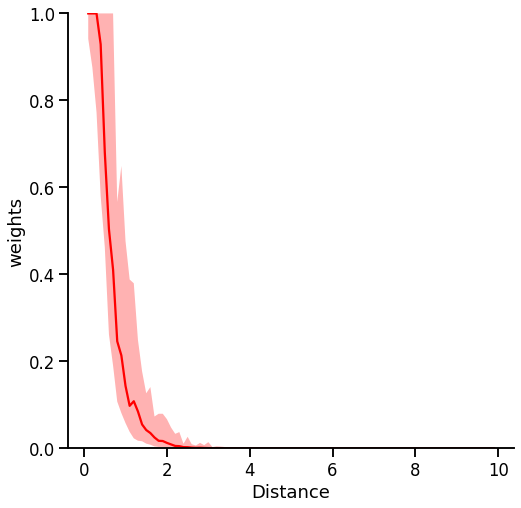

In [76]:
# plot distance vs. weights
mean_weights = np.array(mean_weights)
quantile_25_weights = np.array(quantile_25_weights)
quantile_75_weights = np.array(quantile_75_weights)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(d, mean_weights, c='r')
ax.fill_between(d, quantile_25_weights, quantile_75_weights, facecolor='r', alpha=.3)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_xlabel('Distance')
ax.set_ylabel('weights')
ax.set_ylim(0,1)

# Gaussian Sparse Parity without Noise

In [77]:
# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-3),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=False)
fit_kwargs = {
    "epochs": 200,
    "batch_size": 32,
    "verbose": False,
    "validation_data": (X_val[:, :3], keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [78]:
# network architecture
def getNN():
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base = keras.Sequential()
    network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer, input_shape=(3,)))
    network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [79]:
# train Vanilla NN
vanilla_nn = getNN()
vanilla_nn.fit(X[:, :3], keras.utils.to_categorical(y), **fit_kwargs)

# train KDN
model_kdn = kdn(
    network=vanilla_nn,
    polytope_compute_method="all",
    k=1e-5,
    weighting_method="lin",
    T=2,
    c=2,
    verbose=False,
)
model_kdn.fit(X[:, :3], y)

In [80]:
accuracy_kdn = np.mean(
        model_kdn.predict(X_test[:, :3]) == y_test
    )
accuracy_nn = np.mean(
        np.argmax(vanilla_nn.predict(X_test[:, :3]), axis=1) == y_test
    )

print("NN Accuracy:", accuracy_nn)
print("KDN Accuracy:", accuracy_kdn)

NN Accuracy: 0.906
KDN Accuracy: 0.924


In [81]:
def compute_weights(X_, polytope_id):
    M_ref = model_kdn._get_activation_pattern(polytope_id)
    start = 0
    A = X_
    A_ref = X_
    d = 0
    for l in range(len(model_kdn.network_shape)-1):
        end = start + model_kdn.network_shape[l]
        M_l = M_ref[start:end]
        start = end
        W, B = model_kdn.weights[l], model_kdn.biases[l]
        pre_A = A @ W + B
        A = np.maximum(0, pre_A)
        pre_A_ref = A_ref @ W + B
        A_ref = pre_A_ref @ np.diag(M_l) 
        d += np.linalg.norm(A - A_ref, axis=1, ord=2)
    scales = np.exp(-d)
    # scales = d
    return scales

In [82]:
X_0 = X[y==0] # data that belong to class 0
X_0 = X_0[:, :3]

# pick the point closest to the class mean
idx = np.linalg.norm(X_0[:, :3] - [0.5, 0.5, 0.5], ord=2, axis=1).argsort()[0]
X_ref = X_0[idx]

# define the distances
d = np.arange(0.1, 10, 0.1)

# get the activation pattern of the reference point
X_ref_polytope_id = model_kdn._get_polytope_memberships(X_ref.reshape(1, len(X_ref)))[0][0]

rep = 300
distance_replicates = {}
for i in range(len(d)):
    tmpp_array = []
    for j in range(rep):
        # sample points which has the same distance from the reference point
        u = np.random.normal(0,1,3)
        u_norm = np.linalg.norm(u)
        X_bar = u/u_norm * d[i] + X_ref
        tmpp_array.append(X_bar)
    distance_replicates[d[i]] = tmpp_array

In [83]:
mean_weights = []
quantile_25_weights = []
quantile_75_weights = []
for i in range(len(d)):
    weights_per_distance = []
    for j in range(rep):
        X_bar = distance_replicates[d[i]][j]
        weight = compute_weights(X_bar.reshape(1, 3), X_ref_polytope_id)
        weights_per_distance.append(weight)
    weights_per_distance = np.array(weights_per_distance)
    mean_weights.append(np.median(weights_per_distance))
    quantile_25_weights.append(
        np.quantile(weights_per_distance, [0.25])[0]
        )
    quantile_75_weights.append( 
        np.quantile(weights_per_distance, [0.75])[0]
        )

(0.0, 1.0)

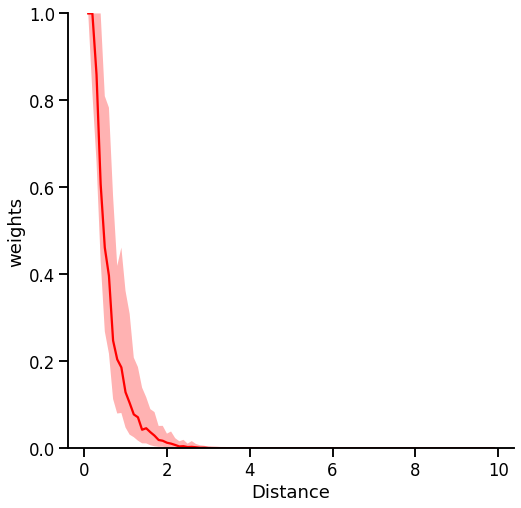

In [84]:
# plot distance vs. weights
mean_weights = np.array(mean_weights)
quantile_25_weights = np.array(quantile_25_weights)
quantile_75_weights = np.array(quantile_75_weights)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(d, mean_weights, c='r')
ax.fill_between(d, quantile_25_weights, quantile_75_weights, facecolor='r', alpha=.3)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_xlabel('Distance')
ax.set_ylabel('weights')
ax.set_ylim(0,1)

# Spiral Dataset

In [23]:
# import standard libraries
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

# import internal libraries
from kdg.kdn import *
from kdg.utils import generate_spirals

In [24]:
# generate training data
X, y = generate_spirals(10000, noise=0.8, n_class=2)
X_val, y_val = generate_spirals(500, noise=0.8, n_class=2)
X_test, y_test = generate_spirals(1000, noise=0.8, n_class=2)

In [28]:
# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=False)
fit_kwargs = {
    "epochs": 300,
    "batch_size": 32,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [29]:
# network architecture
def getNN():
    network_base = keras.Sequential()
    network_base.add(keras.layers.Dense(10, activation="relu", input_shape=(2,)))
    network_base.add(keras.layers.Dense(10, activation="relu"))
    network_base.add(keras.layers.Dense(10, activation="relu"))
    network_base.add(keras.layers.Dense(5, activation="relu"))
    network_base.add(keras.layers.Dense(units=2, activation="softmax"))
    network_base.compile(**compile_kwargs)
    return network_base

In [30]:
# train Vanilla NN
vanilla_nn = getNN()
history = vanilla_nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

# train KDN
model_kdn = kdn(
    network=vanilla_nn,
    k=1e-5,
    polytope_compute_method="all",
    weighting_method="lin",
    T=2,
    c=2,
    verbose=False,
)
model_kdn.fit(X, y)

In [31]:
accuracy_kdn = np.mean(
        model_kdn.predict(X_test) == y_test
    )
accuracy_nn = np.mean(
        np.argmax(vanilla_nn.predict(X_test), axis=1) == y_test
    )

print("NN Accuracy:", accuracy_nn)
print("KDN Accuracy:", accuracy_kdn)

NN Accuracy: 0.953
KDN Accuracy: 0.957


In [59]:
def compute_weights(X_, polytope_id):
    M_ref = model_kdn._get_activation_pattern(polytope_id)
    start = 0
    A = X_
    A_ref = X_
    d = 0
    for l in range(len(model_kdn.network_shape)-1):
        end = start + model_kdn.network_shape[l]
        M_l = M_ref[start:end]
        start = end
        W, B = model_kdn.weights[l], model_kdn.biases[l]
        pre_A = A @ W + B
        A = np.maximum(0, pre_A)
        pre_A_ref = A_ref @ W + B
        A_ref = pre_A_ref @ np.diag(M_l) 
        d += np.linalg.norm(A - A_ref, axis=1, ord=2)
    scales = np.exp(-d)
    # scales = d
    return scales

In [53]:
# pick the point closest to the spirall origin
idx = np.linalg.norm(X - [0, 0], ord=2, axis=1).argsort()[0]
X_ref = X[idx]

# define the distances
d = np.arange(0.01, 1, 0.01)

# get the activation pattern of the reference point
X_ref_polytope_id = model_kdn._get_polytope_memberships(X_ref.reshape(1, 2))[0][0]
a_ref = np.binary_repr(X_ref_polytope_id, width=model_kdn.num_fc_neurons)[::-1]
a_ref = np.array(list(a_ref)).astype('int')

rep = 300
distance_replicates = {}
for i in range(len(d)):
    tmpp_array = []
    for j in range(rep):
        # sample points which has the same distance from the reference point
        u = np.random.normal(0,1,2)
        u_norm = np.linalg.norm(u)
        X_bar = u/u_norm * d[i] + X_ref
        tmpp_array.append(X_bar)
    distance_replicates[d[i]] = tmpp_array

In [60]:
mean_weights = []
quantile_25_weights = []
quantile_75_weights = []
for i in range(len(d)):
    weights_per_distance = []
    for j in range(rep):
        X_bar = distance_replicates[d[i]][j]
        weight = compute_weights(X_bar.reshape(1, 2), X_ref_polytope_id)
        weights_per_distance.append(weight)
    weights_per_distance = np.array(weights_per_distance)
    mean_weights.append(np.median(weights_per_distance))
    quantile_25_weights.append(
        np.quantile(weights_per_distance, [0.25])[0]
        )
    quantile_75_weights.append( 
        np.quantile(weights_per_distance, [0.75])[0]
        )

(0.0, 1.0)

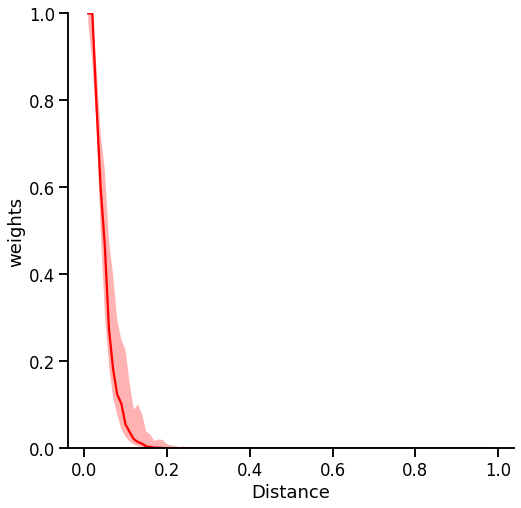

In [61]:
# plot distance vs. weights
mean_weights = np.array(mean_weights)
quantile_25_weights = np.array(quantile_25_weights)
quantile_75_weights = np.array(quantile_75_weights)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(d, mean_weights, c='r')
ax.fill_between(d, quantile_25_weights, quantile_75_weights, facecolor='r', alpha=.3)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_xlabel('Distance')
ax.set_ylabel('weights')
ax.set_ylim(0,1)

# KDF on Spiral Dataset

In [86]:
# import standard libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import internal libraries
from kdg.kdf import *
from kdg.utils import generate_spirals

In [87]:
# generate training data
X, y = generate_spirals(10000, noise=0.8, n_class=2)
X_val, y_val = generate_spirals(500, noise=0.8, n_class=2)
X_test, y_test = generate_spirals(1000, noise=0.8, n_class=2)

In [88]:
n_estimators = 200
model_kdf = kdf(kwargs={"n_estimators": n_estimators})
model_kdf.fit(X, y)

In [90]:
accuracy_kdf = np.mean(
        model_kdf.predict(X_test) == y_test
    )
accuracy_rf = np.mean(
        model_kdf.rf_model.predict(X_test) == y_test
    )

print("RF Accuracy:", accuracy_rf)
print("KDF Accuracy:", accuracy_kdf)

RF Accuracy: 0.94
KDF Accuracy: 0.936


In [134]:
def compute_weights(X_, X_ref):
    a_ref = np.array(
                    [tree.apply(X_ref) for tree in model_kdf.rf_model.estimators_]
                ).T
    a = np.array(
                    [tree.apply(X_) for tree in model_kdf.rf_model.estimators_]
                ).T
    matched_samples = np.sum(a == a_ref)
    # scales = matched_samples/ len(a_ref)
    scales = matched_samples
    return scales

In [130]:
# pick the point closest to the spirall origin
idx = np.linalg.norm(X - [0, 0], ord=2, axis=1).argsort()[0]
X_ref = X[idx]

# define the distances
d = np.arange(0.01, 0.4, 0.01)

rep = 300
distance_replicates = {}
for i in range(len(d)):
    tmpp_array = []
    for j in range(rep):
        # sample points which has the same distance from the reference point
        u = np.random.normal(0,1,2)
        u_norm = np.linalg.norm(u)
        X_bar = u/u_norm * d[i] + X_ref
        tmpp_array.append(X_bar)
    distance_replicates[d[i]] = tmpp_array

In [135]:
mean_weights = []
quantile_25_weights = []
quantile_75_weights = []
for i in range(len(d)):
    weights_per_distance = []
    for j in range(rep):
        X_bar = distance_replicates[d[i]][j]
        weight = compute_weights(X_bar.reshape(1, 2), X_ref.reshape(1, 2))
        weights_per_distance.append(weight)
    weights_per_distance = np.array(weights_per_distance)
    mean_weights.append(np.median(weights_per_distance))
    quantile_25_weights.append(
        np.quantile(weights_per_distance, [0.25])[0]
        )
    quantile_75_weights.append( 
        np.quantile(weights_per_distance, [0.75])[0]
        )

Text(0, 0.5, 'Number of Matched Samples')

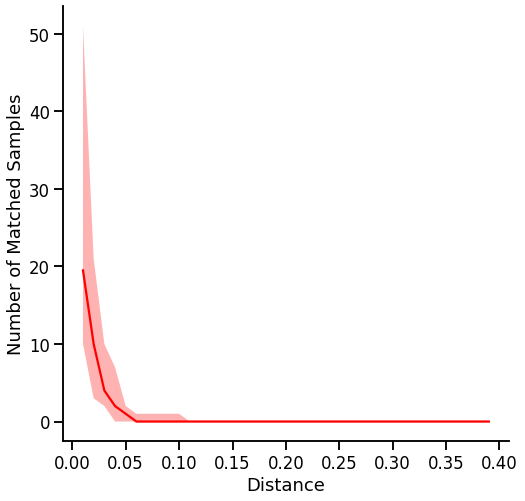

In [139]:
# plot distance vs. weights
mean_weights = np.array(mean_weights)
quantile_25_weights = np.array(quantile_25_weights)
quantile_75_weights = np.array(quantile_75_weights)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(d, mean_weights, c='r')
ax.fill_between(d, quantile_25_weights, quantile_75_weights, facecolor='r', alpha=.3)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_xlabel('Distance')
ax.set_ylabel('Number of Matched Samples')
# ax.set_ylim(0,1)